Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

**Goal**: Your goal is to predict whether a client will subscribe to a bank term deposit.

+ Public Score ->  **0.94156**
+ Leaderboard -> **2445**/3266 (top 75%)

**Evaluation**: Submissions are evaluated using **ROC AUC** between the predicted value and the observed target

**Files**:
- train.csv - the training dataset; y is the binary target
- test.csv - the test dataset; your objective is to predict the probability y for each row
- sample_submission.csv - a sample submission file in the correct format

# Sample Submission

| Id    | y   |
|-------|-----|
| 75000 | 0.5 |
| 75001 | 0.5 |
| 75002 | 0.5 |
| ...   | ... |

# Future improvements:
- Hyperparameter tuning using GridSearchCV or RandomizedSearchCV
- Try different models like XGBoost, LightGBM, CatBoost
- Feature selection using techniques like Recursive Feature Elimination (RFE)
- Cross-validation to ensure model robustness
- AUC score seems low, try to improve it
- Create a pipeline for data preprocessing, feature engineering, feature selection, and model training

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_data_path = './data/bank/train.zip' #'/kaggle/input/playground-series-s5e8/train.csv'
test_data_path = './data/bank/test.zip' #'/kaggle/input/playground-series-s5e8/test.csv'
submission_path = 'submission.csv' #'/kaggle/working/submission.csv'

In [3]:
# load the data
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [5]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [6]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [8]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    """Custom transformer to create new features based on existing ones."""

    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure X is a DataFrame with column names
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns)
        X = X.copy()
        _age_bins = [18, 25, 35, 45, 55, 65, 100]
        _age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
        X['age_group'] = pd.cut(X['age'], bins=_age_bins, labels=_age_labels, right=False)
        X['age_group'] = X['age_group'].astype('category').cat.codes
        X['is_balance_negative'] = (X['balance'] < 0).astype(int)
        X['is_pdays_negative'] = (X['pdays'] < 0).astype(int)
        return X

In [9]:
# let's make a IQR_Transformer for Pipeline
class IQRTransformer(BaseEstimator, TransformerMixin):
    """ Custom transformer to drop outliers using IQR method."""
    def __init__(self, columns, is_delete=True):
        self.columns = columns
        self.is_delete = is_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df_out = X.copy()
        for col in self.columns:
            Q1 = df_out[col].quantile(0.25)
            Q3 = df_out[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if self.is_delete:
                df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
            else: # let's cap the outliers
                df_out[col] = df_out[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
        return df_out

In [10]:
# let's split data to X and y
X = train_df.drop(columns=['y'])
y = train_df['y']

In [11]:
# let's split data to train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [12]:
min_max_columns = ['balance', 'duration', 'pdays', 'previous', 'campaign']
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
iqr_columns = ['balance', 'duration', 'pdays', 'previous', 'campaign']

# let's build a pipeline for preprocessing and model training
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), min_max_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns),
        ('drop', 'drop', ['id']),
        ('passthrough', 'passthrough', ['age'])
    ]
)

In [13]:
transformer = Pipeline(steps=[
        ('feature_engineering', FeatureTransformer(X.columns)),
        ('cap_outliers', IQRTransformer(iqr_columns, is_delete=False)),
        ('preprocessor', preprocessor),
])

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
estimator = LogisticRegression(n_jobs=-1, max_iter=100)

param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__max_iter': [100, 200, 500]
}

pipeline = make_pipeline(transformer, estimator )

search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0, return_train_score=False)

search.fit(X_train, y_train)

best_model = search.best_estimator_
best_score = search.best_score_

In [27]:
y_val_pred = best_model.predict(X_val)
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'Validation ROC AUC: {roc_auc:.4f}') # Validation ROC AUC: 0.9541

Validation ROC AUC: 0.9388


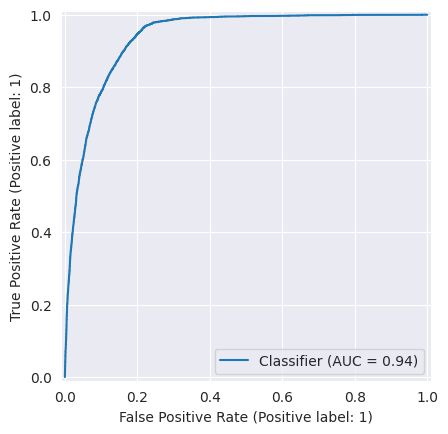

In [28]:
# # let's plot ROC curve
RocCurveDisplay.from_predictions(y_val, y_val_pred)
plt.show()

In [18]:
# # # lets check on cross_validation
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f'Cross-validation ROC AUC scores: {cv_scores}')
print(f'Mean CV ROC AUC: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}')

In [19]:
# # # let's predict on test data
predicted_test_df = test_df.drop(columns=['id', 'age'])
predicted_test_df['y'] = best_model.predict_proba(predicted_test_df)[:, 1]

In [20]:
# # let's create a submission file
submission = predicted_test_df[['id', 'y']]
submission.to_csv(submission_path, index=False)